# Spooky Author Identification: EDA and Text Preprocessing

## Skimming the Text Data
- There are some uncommon/misspelled words such as those used by HPL: "It was all mud an' water, an' the sky was dark, an' the rain was wipin' aout all tracks abaout as fast as could be; but beginnin' at the glen maouth, whar the trees had moved, they was still some o' them awful prints big as bar'ls like he seen Monday."
- There are some mentions of places like "Windsor" and names like "Dr. Johnson"
- There are uses of uncommon words such as "pursy" or made-up words such as "drest" (meaning "dressed")
- UK English is used, such as "travellers" or "neighbour"
- There are some words with multiple spellings, such as "until" vs. "untill"
- EAP sometimes writes in French: "que tout notre raisonnement se rèduit à céder au sentiment;"
- There are no hyphenated words
- Since the data is in CSV format, there are odd uses of punctuation marks like triple double quotes: """The nitre"" I said: ""see, it increases."
- There do not appear to be any numbers (if they exist, they're spelled out in words)
- Punctuations used are: . , : ; ' " ?
- All caps are rare occurrences

## Import Packages

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '' # '' to run on CPU, '0' to run on the first GPU

In [3]:
# If you don't already have these packages, run this cell
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from packages import *

Using TensorFlow backend.


In [5]:
INPUT_DIR = '../input/'
TRAIN_FILE_PATH = f'{INPUT_DIR}train.csv'
TEST_FILE_PATH = f'{INPUT_DIR}test.csv'
SAMPLE_SUBMISSION_FILE_PATH = f'{INPUT_DIR}sample_submission.csv'

IMAGES_DIR = '../images/'

# Fix a random seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Load Data

In [6]:
train, test, submission = load_data(TRAIN_FILE_PATH, 
                                    TEST_FILE_PATH, 
                                    SAMPLE_SUBMISSION_FILE_PATH)

## Explore Data

In [7]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [8]:
train.shape

(19579, 3)

In [9]:
author_groups = train.groupby('author') # Returns a list-like object of tuples
type(author_groups)

pandas.core.groupby.groupby.DataFrameGroupBy

In [10]:
for author, df in author_groups:
    print(type(author))
    print(type(df))

<class 'str'>
<class 'pandas.core.frame.DataFrame'>
<class 'str'>
<class 'pandas.core.frame.DataFrame'>
<class 'str'>
<class 'pandas.core.frame.DataFrame'>


In [11]:
# How many samples are there per author?
def get_sample_distribution(data, feature):
    print('Sample distribution per {} out of {:,} samples:'.format(feature, len(data)))
    unique_feature_values = data[feature].unique()
    for value in unique_feature_values:
        sample_count = len(data[data[feature]==value])
        percentage = (sample_count / len(data)) * 100
        print(value, '{:,} samples or {:.2f}%'.format(sample_count, percentage))
        
get_sample_distribution(train, 'author')

Sample distribution per author out of 19,579 samples:
EAP 7,900 samples or 40.35%
HPL 5,635 samples or 28.78%
MWS 6,044 samples or 30.87%


In [12]:
# Let's concatenate all of the text entries per author
def get_text_per_feature(data, feature, text_feature, sep=' '):
    print('Character count of the text per {}:'.format(feature))
    texts = []
    unique_feature_values = data[feature].unique()
    for value in unique_feature_values:
        entire_text = data[data[feature]==value][text_feature].str.cat(sep=sep)
        print(value, '{:,}'.format(len(entire_text)))
        texts.append((value, entire_text))
    return texts
        
author_texts = get_text_per_feature(train, 'author', 'text')

Character count of the text per author:
EAP 1,131,484
HPL 883,812
MWS 922,675


### Calculate basic statistics over all the text samples

#### Character length per sentence

In [13]:
# Retrieve the character length of each sentence
char_lens = train['text'].apply(lambda s: len(s))
char_lens.head()

0    231
1     71
2    200
3    206
4    174
Name: text, dtype: int64

In [14]:
# count: The number of sentences
# mean: Mean length of a sentence
# std: Standard deviation of the length of a sentence
# min: Minimum length of a sentence
# 25%: 25% of sentences are length 81 or shorter
# 50%: Median length of a sentence
# 75%: 75% of sentences are length 191 or shorter
# max: Maximum length of a sentence
char_lens.describe()

count    19579.000000
mean       149.057408
std        106.800189
min         21.000000
25%         81.000000
50%        128.000000
75%        191.000000
max       4663.000000
Name: text, dtype: float64

#### Word length per sentence

In [15]:
# Retrieve the character length of each sentence
word_lens = train['text'].apply(lambda s: len(s.split(' ')))
word_lens.head()

0    41
1    14
2    36
3    34
4    27
Name: text, dtype: int64

In [16]:
# count: The number of sentences
# mean: Mean word length of a sentence
# std: Standard deviation of the word length of a sentence
# min: Minimum word length of a sentence
# 25%: 25% of sentences are word length 15 or shorter
# 50%: Median word length of a sentence
# 75%: 75% of sentences are word length 34 or shorter
# max: Maximum word length of a sentence
word_lens.describe()

count    19579.000000
mean        26.730477
std         19.048353
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: text, dtype: float64

In [17]:
# The min and the max appear to be outliers; let's view what these sentences are
train.iloc[word_lens.idxmin()]

id                      id22015
text      "PIQUANT EXPRESSIONS.
author                      EAP
Name: 6936, dtype: object

In [18]:
train.iloc[word_lens.idxmax()]

id                                                  id27184
text      Diotima approached the fountain seated herself...
author                                                  MWS
Name: 9215, dtype: object

In [19]:
# Ratio of "number of samples" (S) to "number of words per sample" (W)
len(train) / word_lens.mean()
# Since this is less than 1500, per Google's
# https://developers.google.com/machine-learning/guides/text-classification/step-2-5
# we should use n-gram inputs into an MLP.

732.4598189377784

### Analyze the count features per author

In [20]:
def construct_vocabulary(texts, construct_tokens):
    vocab = { 'ALL': Counter() }
    
    # Word counts
    print('Total word count of the text per author:')
    for tup in texts:
        author = tup[0]
        text = tup[1]
        tokens = construct_tokens(text)
        print(author, '{:,}'.format(len(tokens)))
        
        # Calculate vocabulary word frequencies (how many times a word appears in the text)
        vocab[author] = Counter()
        for word in tokens:
            vocab['ALL'][word] += 1
            vocab[author][word] += 1

    # Vocabulary size or unique word counts
    print('\nVocabulary size of the text per author:')
    for author in vocab:
        print(author, '{:,}'.format(len(vocab[author])))
        
    return vocab

In [21]:
vocab = construct_vocabulary(author_texts, lambda x: x.split(' '))

Total word count of the text per author:
EAP 200,995
HPL 156,651
MWS 165,710

Vocabulary size of the text per author:
ALL 47,556
EAP 26,521
HPL 22,527
MWS 20,251


In [22]:
# View the most common words per author
for author in vocab:
    print(author, '\n', vocab[author].most_common(10), '\n')

ALL 
 [('the', 33296), ('of', 20851), ('and', 17059), ('to', 12615), ('I', 10382), ('a', 10359), ('in', 8787), ('was', 6440), ('that', 5988), ('my', 5037)] 

EAP 
 [('the', 13927), ('of', 8930), ('and', 5222), ('to', 4625), ('a', 4514), ('in', 3750), ('I', 3598), ('was', 2109), ('that', 2085), ('my', 1666)] 

HPL 
 [('the', 10330), ('and', 5908), ('of', 5792), ('a', 3230), ('to', 3219), ('I', 2629), ('in', 2558), ('was', 2126), ('that', 1902), ('had', 1744)] 

MWS 
 [('the', 9039), ('of', 6129), ('and', 5929), ('to', 4771), ('I', 4155), ('a', 2615), ('in', 2479), ('my', 2469), ('was', 2205), ('that', 2001)] 



**Comments:**

As we can see from the results above, there is nothing too distinguishable between author vocabularies due to common words such as "the", "of", and "and"; these are called *stopwords*. Let's remove them and apply other text preprocessing techniques as we see fit. But beforehand, let's review the least common words.

In [23]:
# View the least common words per author
for author in vocab:
    print(author, '\n', list(reversed(vocab[author].most_common()))[0:10], '\n')

ALL 
 [('Ancona.', 1), ('Gulph;', 1), ('Adriatic', 1), ('Stress', 1), ('feel."', 1), ('legislators', 1), ('connection?', 1), ('domestic,', 1), ('curtain,', 1), ('praising', 1)] 

EAP 
 [('received."', 1), ('outright.', 1), ('faints', 1), ('agir', 1), ('faut', 1), ('Mais', 1), ('spasm.', 1), ('brush.', 1), ('fancied,', 1), ('turning,', 1)] 

HPL 
 [('mirth.', 1), ('noon.', 1), ('going,', 1), ('negative', 1), ('"salt', 1), ('traditional', 1), ('Average', 1), ('flattening', 1), ('casements', 1), ('passageway.', 1)] 

MWS 
 [('Ancona.', 1), ('Gulph;', 1), ('Adriatic', 1), ('Stress', 1), ('feel."', 1), ('pause,', 1), ('legislators', 1), ('connection?', 1), ('domestic,', 1), ('universe,', 1)] 



**Comments:**

There are many words that only appear to occur once throughout the corpus or per author, so let's remove them from the vocabulary, along with other less frequent words, since they aren't very predictive.

## Text Preprocessing

In [24]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [25]:
t1 = "The story wasn't so terrible, she thought."
process_text(t1, lower=True, return_tokens=True)

['the', 'story', 'was', "n't", 'so', 'terrible', ',', 'she', 'thought', '.']

In [26]:
process_text(t1, lower=True, remove_stopwords=True, return_tokens=True)

['story', "n't", 'terrible', ',', 'thought', '.']

In [27]:
# Let's remove stopwords
vocab = construct_vocabulary(author_texts, lambda x: process_text(x,
                                                                  lower=True,
                                                                  remove_stopwords=True,
                                                                  return_tokens=True))

Total word count of the text per author:
EAP 127,478
HPL 98,577
MWS 101,892

Vocabulary size of the text per author:
ALL 25,236
EAP 15,371
HPL 14,416
MWS 11,457


**Comments:**

Note that before text preprocessing, we had the following:
```
Total word count of the text per author:
EAP 200,995
HPL 156,651
MWS 165,710

Vocabulary size of the text per author:
ALL 47,556
EAP 26,521
HPL 22,527
MWS 20,251
```

Therefore, text preprocessing drastically reduced the total vocabulary size and word counts.

In [28]:
# View the most common words per author
for author in vocab:
    print(author, '\n', vocab[author].most_common(10), '\n')

ALL 
 [(',', 38220), ('.', 19062), (';', 5159), ('``', 2762), ("''", 2207), ('one', 1623), ('upon', 1411), ("'s", 1355), ('could', 1330), ('would', 1258)] 

EAP 
 [(',', 17594), ('.', 7655), ('``', 1628), ("''", 1359), (';', 1354), ('upon', 1025), ('one', 655), ('?', 510), ('could', 457), ('would', 416)] 

HPL 
 [(',', 8581), ('.', 5699), (';', 1143), ("'s", 612), ("'", 547), ('one', 491), ('could', 490), ('old', 392), ('would', 367), ('``', 297)] 

MWS 
 [(',', 12045), ('.', 5708), (';', 2662), ('``', 837), ("''", 632), ('one', 477), ('would', 475), ('?', 419), ('could', 383), ("'s", 352)] 



In [29]:
# Let's remove punctuation
vocab = construct_vocabulary(author_texts, lambda x: process_text(x,
                                                                  lower=True,
                                                                  remove_punc=True,
                                                                  remove_stopwords=True,
                                                                  return_tokens=True))

Total word count of the text per author:
EAP 96,133
HPL 81,149
MWS 78,800

Vocabulary size of the text per author:
ALL 25,275
EAP 15,276
HPL 14,576
MWS 11,458


In [30]:
# View the most common words per author
for author in vocab:
    print(author, '\n', vocab[author].most_common(10), '\n')

ALL 
 [('one', 1614), ('upon', 1411), ('could', 1316), ('would', 1241), ('man', 730), ('time', 729), ('yet', 715), ('said', 704), ('even', 701), ('might', 629)] 

EAP 
 [('upon', 1025), ('one', 652), ('could', 453), ('would', 409), ('said', 356), ('little', 275), ('say', 267), ('well', 267), ('made', 263), ('even', 261)] 

HPL 
 [('one', 488), ('could', 480), ('old', 392), ('would', 357), ('like', 273), ('seemed', 272), ('man', 260), ('night', 254), ('things', 239), ('time', 238)] 

MWS 
 [('would', 475), ('one', 474), ('could', 383), ('life', 328), ('yet', 318), ('love', 273), ('us', 272), ('might', 269), ('heart', 262), ('raymond', 248)] 



In [31]:
# Let's try excluding the least predictive words

COUNT_THRESHOLD = 3 # Words should appear at least thrice to remain in the vocabulary

print(f'Vocab size before applying count threshold of {COUNT_THRESHOLD}:', len(vocab['ALL']))
all_vocab = Counter({ word: count for word, count in vocab['ALL'].items() if count >= COUNT_THRESHOLD })
        
print(f'Vocab size after applying count threshold of {COUNT_THRESHOLD}:', len(all_vocab))

Vocab size before applying count threshold of 3: 25275
Vocab size after applying count threshold of 3: 12094


In [32]:
COUNT_THRESHOLD = 2 # Words should appear at least twice to remain in the vocabulary

print(f'Vocab size before applying count threshold of {COUNT_THRESHOLD}:', len(vocab['ALL']))
all_vocab = Counter({ word: count for word, count in vocab['ALL'].items() if count >= COUNT_THRESHOLD })
        
print(f'Vocab size after applying count threshold of {COUNT_THRESHOLD}:', len(all_vocab))

Vocab size before applying count threshold of 2: 25275
Vocab size after applying count threshold of 2: 15798


## Exploratory Visualization

In [33]:
sns.set()

### Visualize the 15 most common unigrams per author

In [34]:
def construct_ngram_counts_dataframe(vocab, ngram, top_most_common=10):
    rows = []
    for author in ['EAP', 'HPL', 'MWS']:
        for tup in vocab[author].most_common(top_most_common):
            rows.append({
                ngram: tup[0],
                'count': tup[1],
                'author': author,
            })
    return pd.DataFrame(rows)

In [35]:
unigram_counts = construct_ngram_counts_dataframe(vocab, 'unigram', 15)
print(unigram_counts.shape)
unigram_counts.head()

(45, 3)


,author,count,unigram
0,EAP,1025,upon
1,EAP,652,one
2,EAP,453,could
3,EAP,409,would
4,EAP,356,said


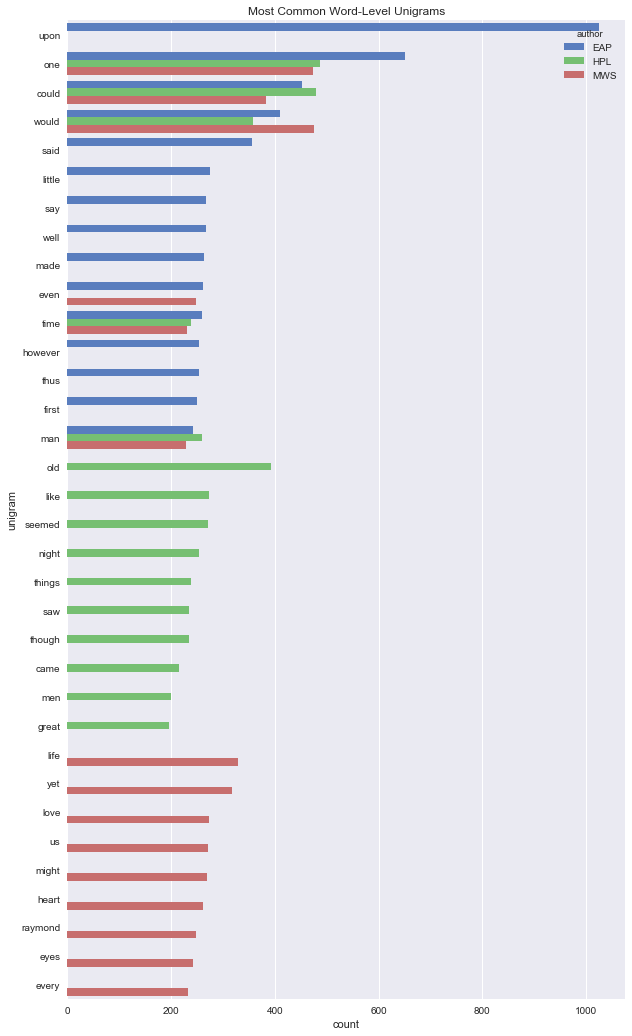

In [36]:
fig, ax = plt.subplots(figsize=(10,18))
unigram_counts_plot = sns.barplot(x='count',
                                  y='unigram', 
                                  hue='author',
                                  data=unigram_counts,
                                  ax=ax,
                                  palette='muted').set_title(
                                      'Most Common Word-Level Unigrams')

### Visualize the 15 most common bigrams per author

In [37]:
def process_author_text(author):
    return list(train[train['author']==author]['text'].apply(
        lambda x: process_text(x,
                               lower=True,
                               remove_punc=True,
                               remove_stopwords=True)).values)

author_sentences = {
    'EAP': process_author_text('EAP'),
    'HPL': process_author_text('HPL'),
    'MWS': process_author_text('MWS'),
}

In [38]:
# Tokenize a string into word-level bigrams; does not count a single word as a bigram
def tokenize_bigrams(doc):
    tokens = doc.split(' ')
    bigrams = []
    # Loop from index 1 to the last index in tokens
    for i in range(1, len(tokens)):
        # Does not enter the loop if there is only one word in the doc
        bigram = f'{tokens[i-1]} {tokens[i]}'
        bigrams.append(bigram)
    return bigrams

In [39]:
def construct_bigrams(texts):
    vocab = { 'ALL': Counter() }
    
    # Bigram counts
    print('Total bigram count of the text per author:')
    for author in texts:
        author_texts = texts[author]
        author_bigrams = []
        
        for doc in author_texts:
            doc_bigrams = tokenize_bigrams(doc)
            author_bigrams.extend(doc_bigrams)
        print(author, '{:,}'.format(len(author_bigrams)))
        
        # Calculate vocabulary bigram frequencies
        # (how many times a bigram appears in the text)
        vocab[author] = Counter()
        for bigram in author_bigrams:
            vocab['ALL'][bigram] += 1
            vocab[author][bigram] += 1

    # Unique bigram counts
    print('\nUnique bigram counts of the text per author:')
    for author in vocab:
        print(author, '{:,}'.format(len(vocab[author])))
        
    return vocab

In [40]:
vocab_bigrams = construct_bigrams(author_sentences)

Total bigram count of the text per author:
EAP 88,235
HPL 75,514
MWS 72,757

Unique bigram counts of the text per author:
ALL 209,277
EAP 78,854
HPL 69,515
MWS 67,578


In [41]:
bigram_counts = construct_ngram_counts_dataframe(vocab_bigrams, 'bigram', 15)
print(bigram_counts.shape)
bigram_counts.head()

(45, 3)


,author,bigram,count
0,EAP,let us,50
1,EAP,three four,23
2,EAP,one two,23
3,EAP,ha ha,22
4,EAP,every thing,22


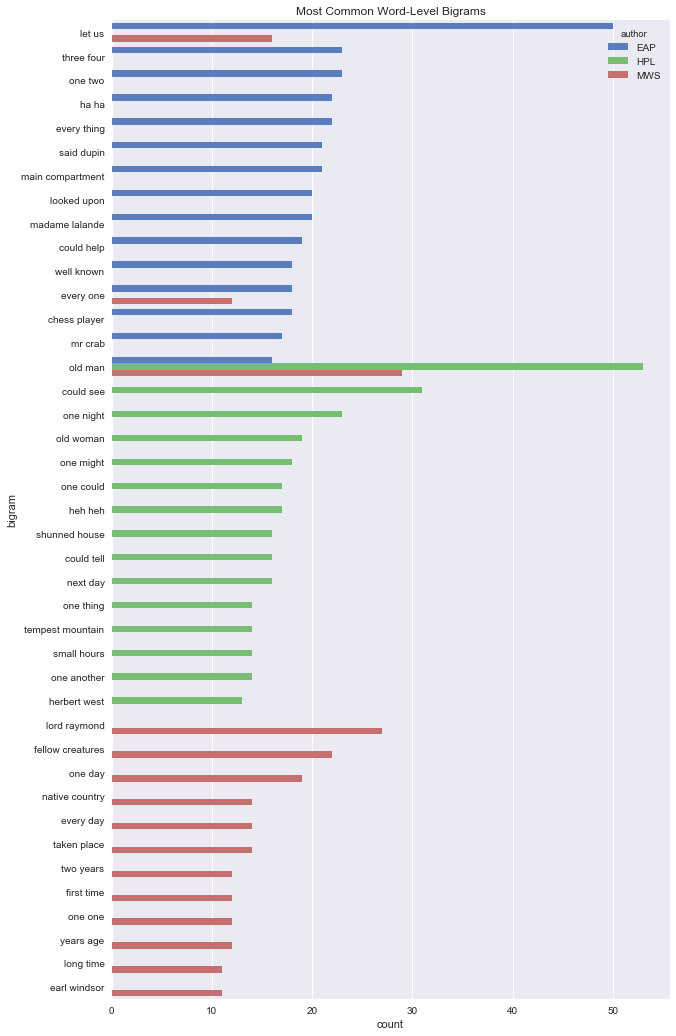

In [42]:
fig, ax = plt.subplots(figsize=(10,18))
bigram_counts_plot = sns.barplot(x='count',
                                 y='bigram',
                                 hue='author',
                                 data=bigram_counts,
                                 ax=ax,
                                 palette='muted').set_title(
                                     'Most Common Word-Level Bigrams')

In [44]:
unigram_counts_plot.figure.savefig(f'{IMAGES_DIR}unigram_counts_plot.png')
bigram_counts_plot.figure.savefig(f'{IMAGES_DIR}bigram_counts_plot.png')